<a href="https://colab.research.google.com/github/Shashiawari/Sarcasm_Detection/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sarcasm Detection using Sarcasm Headlines datasets**

**Data Loading**: The code reads and loads the JSON data.

**Preprocessing**: Text is tokenized using BERT's tokenizer, and the Dataset class is defined to format the data for training.

**Model**: BERT (bert-base-uncased) is used as the base model for sarcasm detection.

**Training**: Trainer is used for training, with accuracy, precision, recall, and F1-score as evaluation metrics.

# **Importing necessary Libraries**

In [ ]:
import json
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset

# **Load dataset**

In [ ]:
with open('/content/Sarcasm_Headlines_Dataset.json', 'r') as file:
    data = [json.loads(line) for line in file]

# Convert to DataFrame
df = pd.DataFrame(data)

# **Data Preprocessing**

In [ ]:
# Keep relevant columns
df = df[['headline', 'is_sarcastic']]

In [ ]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
import re

In [ ]:
#  Basic Text Cleaning Function
def clean_text(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply text cleaning
df['headline'] = df['headline'].apply(clean_text)

In [ ]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret bl...,0
1,the roseanne revival catches up to our thorny ...,0
2,mom starting to fear sons web series closest t...,1
3,boehner just wants wife to listen not come up ...,1
4,jk rowling wishes snape happy birthday in the ...,0


# **Split Data into Train and Validation Sets**

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42
)

#  **Tokenize with BERT Tokenizer**

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# **Load tokenizer and model**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Dataset class
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare datasets
train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer)
val_dataset = SarcasmDataset(val_texts, val_labels, tokenizer)

# **Define metrics**

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# **Training arguments**

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_dir='./logs',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# **Train the Model**

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.316300,0.291466,0.911082,0.889954,0.910060,0.899895
2,0.174800,0.342027,0.917821,0.899121,0.915601,0.907286
3,0.048000,0.439038,0.922127,0.917388,0.904092,0.910691


TrainOutput(global_step=8013, training_loss=0.19682192145482413, metrics={'train_runtime': 1231.2195, 'train_samples_per_second': 52.063, 'train_steps_per_second': 6.508, 'total_flos': 1515276095591880.0, 'train_loss': 0.19682192145482413, 'epoch': 3.0})

# **Model Evaluation**

In [ ]:
trainer.evaluate()

{'eval_loss': 0.43903759121894836,
 'eval_accuracy': 0.9221265443654062,
 'eval_precision': 0.9173875432525952,
 'eval_recall': 0.9040920716112532,
 'eval_f1': 0.9106912838127952,
 'eval_runtime': 13.4924,
 'eval_samples_per_second': 395.928,
 'eval_steps_per_second': 49.509,
 'epoch': 3.0}

# **Save the Model**

In [ ]:
trainer.save_model("./sarcasm_model")

# **Function for Predictions**

In [ ]:
# Define new headlines for prediction
new_headlines = [
    "I'm thrilled to be stuck in traffic for hours",
    "NASA launches new mission to Mars",
    "What a beautiful day to be fired!",
    "The government announced another tax hike"
]

# Preprocess the new headlines similar to training data
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

# Create a dataset for prediction
pred_dataset = PredictionDataset(new_headlines, tokenizer)

# Make predictions
predictions = trainer.predict(pred_dataset)

# Process predictions
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Print the results
for i, headline in enumerate(new_headlines):
    label = pred_labels[i].item()
    label_str = "Sarcastic" if label == 1 else "Not Sarcastic"
    print(f"Headline: {headline}\nPrediction: {label_str}\n")

Headline: I'm thrilled to be stuck in traffic for hours
Prediction: Not Sarcastic

Headline: NASA launches new mission to Mars
Prediction: Sarcastic

Headline: What a beautiful day to be fired!
Prediction: Not Sarcastic

Headline: The government announced another tax hike
Prediction: Not Sarcastic



# **Visualization of Predictions through Pie-Chart**

In [ ]:
import matplotlib.pyplot as plt

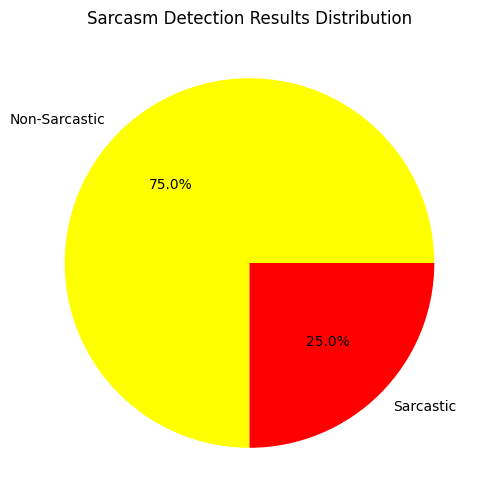

In [ ]:
# Prepare dataset for prediction
pred_dataset = PredictionDataset(new_headlines, tokenizer)

# Run predictions
predictions = trainer.predict(pred_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# Count sarcastic and non-sarcastic predictions
sarcastic_count = sum(pred_labels == 1)
non_sarcastic_count = sum(pred_labels == 0)

# Visualization - Pie Chart
plt.figure(figsize=(6, 6))
plt.pie([non_sarcastic_count, sarcastic_count], labels=['Non-Sarcastic', 'Sarcastic'], autopct='%1.1f%%', colors=['yellow', 'red'])
plt.title("Sarcasm Detection Results Distribution")
plt.show()

# **Plot training and validation loss over epochs**

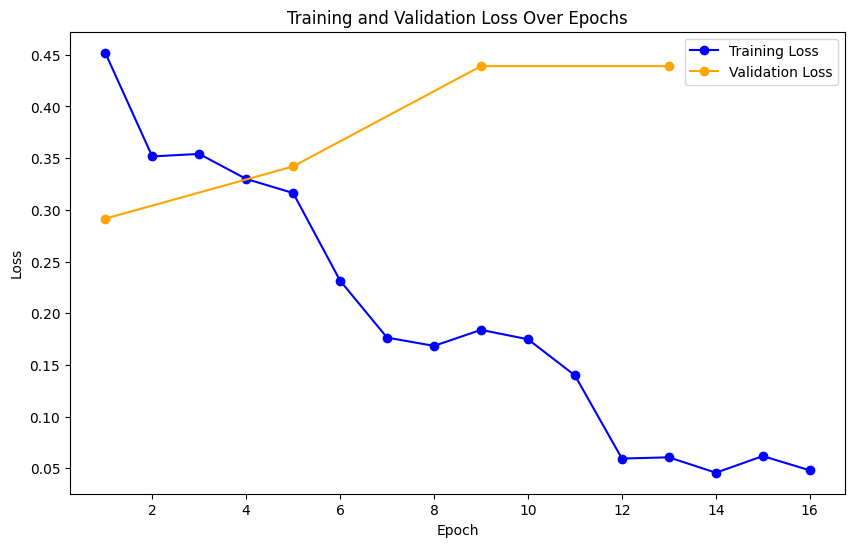

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Adjust epochs for eval_loss to match its length
eval_epochs = range(1, len(train_loss) + 1, int(len(train_loss) / len(eval_loss))) # Calculate epochs for eval_loss based on train_loss length

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', marker='o', color='blue')
plt.plot(eval_epochs, eval_loss, label='Validation Loss', marker='o', color='orange') # Use eval_epochs for plotting eval_loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

# **Plot accuracy**

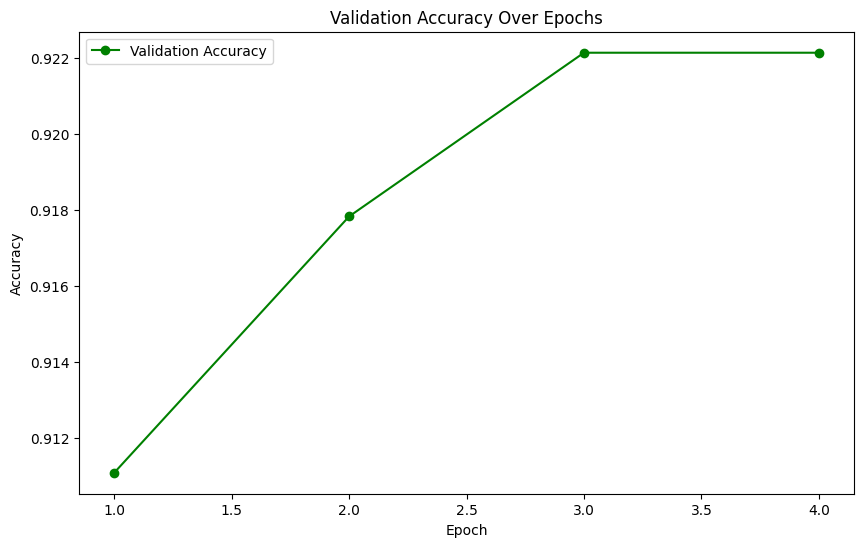

In [ ]:
train_accuracy = [log["eval_accuracy"] for log in trainer.state.log_history if "eval_accuracy" in log]

if train_accuracy:
    # Define epochs based on the length of train_accuracy
    epochs = range(1, len(train_accuracy) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracy, label='Validation Accuracy', marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()
    plt.show()